In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler,  RobustScaler
import pickle
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2M
import numpy as np
import gc


2024-04-09 15:47:58.566118: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 15:47:59.140513: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
pickle_file_path = './data/test_df.pickle'

with open(pickle_file_path, 'rb') as f:
    test_df = pickle.load(f)

pickle_file_path = './data/train_df.pickle'

with open(pickle_file_path, 'rb') as f:
    train_df = pickle.load(f)
    



In [3]:



mean_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
# FEATURE_COLS = test_df.columns[1:-4].tolist()

selected_features_pickle_path = './data/selected_features_list.pickle'
with open(selected_features_pickle_path, 'rb') as f:
    FEATURE_COLS = pickle.load(f)

print(FEATURE_COLS)



['WORLDCLIM_BIO1_annual_mean_temperature', 'WORLDCLIM_BIO12_annual_precipitation', 'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month', 'WORLDCLIM_BIO15_precipitation_seasonality', 'WORLDCLIM_BIO4_temperature_seasonality', 'WORLDCLIM_BIO7_temperature_annual_range', 'SOIL_bdod_100.200cm_mean_0.01_deg', 'SOIL_bdod_15.30cm_mean_0.01_deg', 'SOIL_bdod_30.60cm_mean_0.01_deg', 'SOIL_bdod_60.100cm_mean_0.01_deg', 'SOIL_phh2o_0.5cm_mean_0.01_deg', 'SOIL_phh2o_100.200cm_mean_0.01_deg', 'SOIL_phh2o_15.30cm_mean_0.01_deg', 'SOIL_phh2o_30.60cm_mean_0.01_deg', 'SOIL_phh2o_5.15cm_mean_0.01_deg', 'SOIL_phh2o_60.100cm_mean_0.01_deg', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m1', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m12', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m12'

In [4]:
def plot_data(df, columns_names):
    plt.figure(figsize=(15, 3))

    # Setting up a grid of plots with 2 columns
    n_cols = 6
    n_rows = len(columns_names) // n_cols + (len(columns_names) % n_cols > 0)

    for i, col in enumerate(columns_names):
        plt.subplot(n_rows, n_cols, i+1)
        sns.kdeplot(df[col], bw_adjust=0.5, fill=False, color='blue')
        plt.title(f'Distribution of {col}')
        plt.xlabel('Value')
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()
    


In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [6]:
train_df[mean_columns].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,49009.000000,49009.000000,49009.000000,49009.000000,49009.000000,49009.000000
mean,0.513258,15.765148,2.553271,1.579387,19.236010,1474.509518
std,0.137069,6.837221,4.221007,0.584798,52.724851,2014.639313
min,0.006996,1.347339,0.004113,0.076517,0.000179,1.108830
25%,0.408186,11.137467,0.292925,1.176888,0.484909,249.790400
50%,0.499013,15.384302,0.637308,1.463930,2.104612,658.022926
75%,0.613369,19.599075,2.656578,1.877676,11.127102,1859.130555
max,0.856600,40.478892,23.294858,3.584879,492.559161,12978.600313


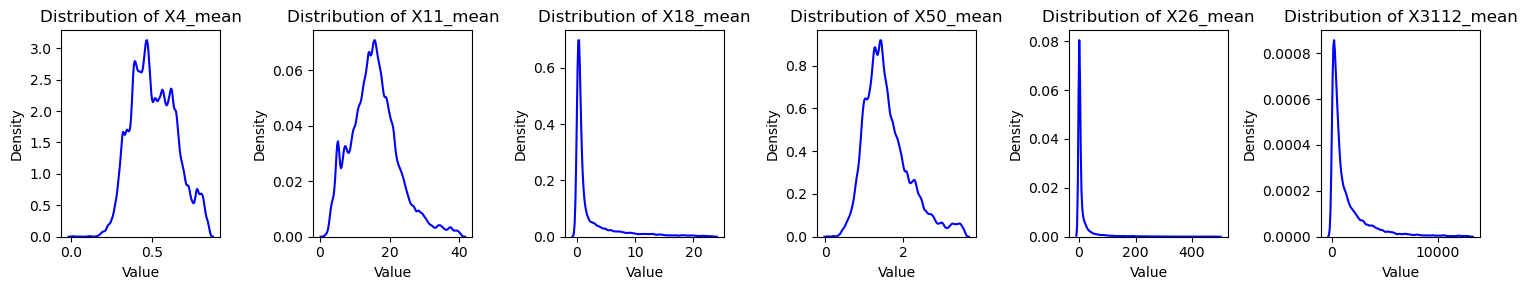

In [7]:
plot_data(train_df, mean_columns)

In [8]:
# train_df[mean_columns] = np.log10(train_df[mean_columns])

In [9]:
train_df[mean_columns].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,49009.000000,49009.000000,49009.000000,49009.000000,49009.000000,49009.000000
mean,0.513258,15.765148,2.553271,1.579387,19.236010,1474.509518
std,0.137069,6.837221,4.221007,0.584798,52.724851,2014.639313
min,0.006996,1.347339,0.004113,0.076517,0.000179,1.108830
25%,0.408186,11.137467,0.292925,1.176888,0.484909,249.790400
50%,0.499013,15.384302,0.637308,1.463930,2.104612,658.022926
75%,0.613369,19.599075,2.656578,1.877676,11.127102,1859.130555
max,0.856600,40.478892,23.294858,3.584879,492.559161,12978.600313


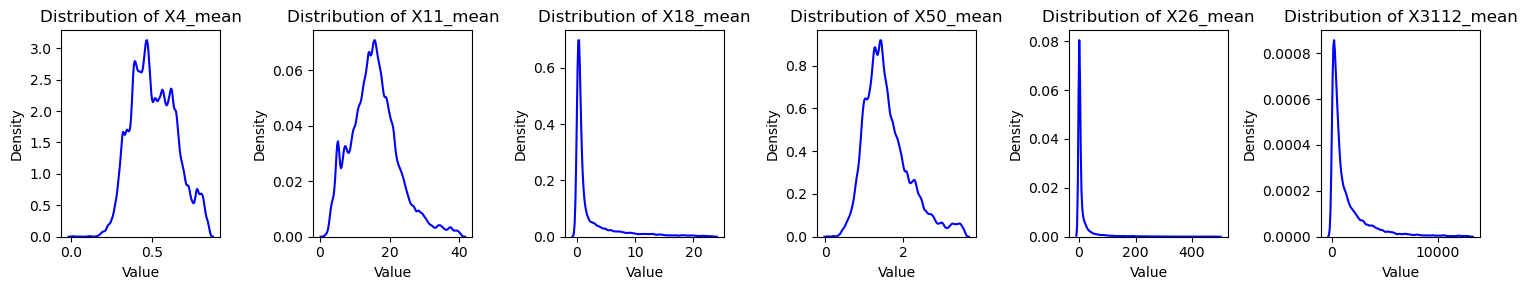

In [10]:
plot_data(train_df, mean_columns)

In [11]:
print(train_df['fold'].value_counts())

# scaler = StandardScaler() # TODO testaa robustscaler
scaler = RobustScaler()

sample_df = train_df.copy()
train_df = sample_df[sample_df.fold != 3]
valid_df = sample_df[sample_df.fold == 3]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")


train_df[FEATURE_COLS] = scaler.fit_transform(train_df[FEATURE_COLS].values)
valid_df[FEATURE_COLS] = scaler.transform(valid_df[FEATURE_COLS].values)

with open('./data/scaler_tabufeatures_train.pickle', 'wb') as f:
    pickle.dump(scaler, f)




fold
1.0    9802
2.0    9802
3.0    9802
0.0    9802
4.0    9801
Name: count, dtype: int64
# Num Train: 39207 | Num Valid: 9802


/tmp/ipykernel_979825/2055694891.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[FEATURE_COLS] = scaler.fit_transform(train_df[FEATURE_COLS].values)
/tmp/ipykernel_979825/2055694891.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[FEATURE_COLS] = scaler.transform(valid_df[FEATURE_COLS].values)


In [12]:
X_train_tab = train_df[FEATURE_COLS].values
X_train_feat = np.stack(train_df['features'].values)
# y_train = train_df[mean_columns].values
y_train = train_df[mean_columns]

X_valid_tab = valid_df[FEATURE_COLS].values 
X_valid_feat = np.stack(valid_df['features'].values)
# y_valid = valid_df[mean_columns].values
y_valid = valid_df[mean_columns]



In [13]:
print(X_train_tab.shape)

(39207, 81)


In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from optuna.integration import TFKerasPruningCallback
import optuna
from keras import regularizers, layers, optimizers, initializers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from datetime import timedelta
import time
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler,  RobustScaler

# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'



def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
    r2 = 1 - ss_res/(ss_tot + tf.keras.backend.epsilon())
    r2 = tf.where(tf.math.is_nan(r2), tf.zeros_like(r2), r2)  # Korvaa NaN-arvot nollilla
    return tf.reduce_mean(tf.maximum(r2, 0.0))


def huber_loss_wrapper(delta):
    def huber_loss(y_true, y_pred):
        return tf.keras.losses.Huber(delta=delta)(y_true, y_pred)
    return huber_loss


global current_delta
def create_model(trial):

    image_features_input = Input(shape=(X_train_feat.shape[1],), name='image_features_input')
    tabular_data_input = Input(shape=(X_train_tab.shape[1],), name='tabular_data_input')

    img_num_layers = trial.suggest_int('Imgage layers', 1, 2)
    max_img_units = 2000
    img_dense = image_features_input

    image_init = trial.suggest_categorical(f'Img_init', choices = ['glorot_uniform', 'he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform',  'random_normal', 'random_uniform'])
    activation_img = trial.suggest_categorical(f'Act_img', choices = ['relu', 'tanh', 'selu', 'LeakyReLU', 'swish', 'elu'])
    drop_img = trial.suggest_float(f'Drop_img', 0.2, 0.7, step=0.1)
    batch_norm_img = trial.suggest_categorical(f'Img_BatchN', choices = ['On', 'Off'])
    for i in range(img_num_layers):

        num_img_units = trial.suggest_int(f'Num_img_{i}', 128, max_img_units, log = True)
        img_dense = Dense(num_img_units, activation=activation_img, kernel_initializer = image_init)(img_dense)
        if batch_norm_img == 'On':
            img_dense = layers.BatchNormalization()(img_dense)
        img_dense = Dropout(drop_img)(img_dense)
        max_img_units = min(max_img_units, num_img_units)


    tab_num_layers = trial.suggest_int('Tabular layers', 1, 2)
    max_tab_units = 1000
    tab_dense = tabular_data_input
    tab_init = trial.suggest_categorical(f'Tab_init', choices = ['glorot_uniform', 'he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform',  'random_normal', 'random_uniform'])
    activation_tab = trial.suggest_categorical(f'Act_tab', choices = ['relu', 'tanh', 'selu', 'LeakyReLU', 'swish', 'elu'])
    drop_tab = trial.suggest_float(f'Drop_tab', 0.2, 0.7, step = 0.1)
    batch_norm_tab = trial.suggest_categorical(f'Tab_BatchN', choices = ['On', 'Off'])
    for i in range(tab_num_layers):

        num_tab_units = trial.suggest_int(f'Num_tab_{i}', 64, max_tab_units, log = True)
        tab_dense = Dense(num_tab_units, activation=activation_tab, kernel_initializer = tab_init)(tab_dense)
        if batch_norm_tab == 'On':
            tab_dense = layers.BatchNormalization()(tab_dense)
        tab_dense = Dropout(drop_tab)(tab_dense)

        max_tab_units = min(max_tab_units, num_tab_units)


    concatenated = Concatenate()([img_dense, tab_dense])
    com_num_layers = trial.suggest_int('Concat layers', 1, 2)
    max_com_units = 3000
    con_init = trial.suggest_categorical(f'Con_init', choices = ['glorot_uniform', 'he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform', 'random_normal', 'random_uniform'])
    activation_common = trial.suggest_categorical(f'Act_con',  choices = ['relu', 'tanh', 'selu', 'LeakyReLU', 'swish', 'elu'])
    drop_common = trial.suggest_float(f'Drop_con', 0.2, 0.7, step = 0.1)
    batch_norm_common = trial.suggest_categorical(f'Com_BatchN', ['On', 'Off'])
    for i in range(com_num_layers):

        num_common_units = trial.suggest_int(f'Num_con_{i}', 128, max_com_units, log = True)
        concatenated = Dense(num_common_units, activation=activation_common, kernel_initializer = con_init)(concatenated)
        if batch_norm_common == 'On':
            concatenated = layers.BatchNormalization()(concatenated)
        concatenated = Dropout(drop_common)(concatenated)

        max_com_units = min(max_com_units, num_common_units)

    output = Dense(6, activation='linear')(concatenated)
    model = Model(inputs=[image_features_input, tabular_data_input], outputs=output)


    optimizer_options = ['adam', 'rmsprop', 'Nadam', 'adamax']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)

    if optimizer_selected == 'adam':
        optimizer = optimizers.Adam()
    elif optimizer_selected == 'rmsprop':
        optimizer = optimizers.RMSprop()
    elif optimizer_selected == 'Nadam':
        optimizer = optimizers.Nadam()
    else:
        optimizer = optimizers.Adamax()

    # delta = trial.suggest_float('delta', 0.0, 2.5)
    # global current_delta
    # current_delta = delta

    model.compile(optimizer=optimizer, loss='mse', metrics=['mse','mae', r2_score])
    # model.compile(optimizer=optimizers.Adam(), loss=huber_loss_wrapper(delta), metrics=['mse','mae', r2_score])
    # model.compile(optimizer= optimizers.Adam(), loss='mse', metrics=['mse','mae', r2_score])
    return model



def objective(trial):

    model = create_model(trial)

    y_train_transformed = y_train.copy()
    y_valid_transformed = y_valid.copy()


    log_base_options = {'none': None, 'log2': 2, 'log10': 10, 'sqrt' : 'sqrt', 'cbrt' : 'cbrt'}
    log_transforms = {}
    for target in mean_columns:
        log_base = trial.suggest_categorical(f'Log_{target}', list(log_base_options.keys()))
        log_transforms[target] = log_base_options[log_base]

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=f"./data/{study_name}_search_model.h5",
            monitor='val_r2_score',
            mode='max',
            save_best_only=True,
            save_weights_only=True,
            verbose=0)


    callbacks = [
                 ReduceLROnPlateau('val_r2_score', patience=2, factor=0.7, mode = 'max'),
                 TerminateOnNaN(),
                 model_checkpoint_callback,
                 EarlyStopping(monitor='val_r2_score', patience=3, mode='max', verbose = 1)
                 ]

    for target, log_base in log_transforms.items():
        if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
            y_train_transformed[target] = np.log(y_train[target]) / np.log(log_base)
            y_valid_transformed[target] = np.log(y_valid[target]) / np.log(log_base)

        elif log_base == 'sqrt':
            y_train_transformed[target] = np.sqrt(y_train[target])
            y_valid_transformed[target] = np.sqrt(y_valid[target])

        elif log_base == 'cbrt':
            y_train_transformed[target] = np.cbrt(y_train[target])
            y_valid_transformed[target] = np.cbrt(y_valid[target])

        else:
            y_train_transformed[target] = y_train[target]
            y_valid_transformed[target] = y_valid[target]

    scaler_base_options = {'Std': StandardScaler(), 'Minmax': MinMaxScaler(), 'Robust': RobustScaler(), 'None': None}
    scaler_transforms = {}
    for target in mean_columns:
        scaler_base = trial.suggest_categorical(f'Scaler_{target}', list(scaler_base_options.keys()))
        scaler_transforms[target] = scaler_base_options[scaler_base]

    for target, scaler in scaler_transforms.items():
        if scaler is not None:
            y_train_transformed[target] = scaler.fit_transform(y_train_transformed[target].values.reshape(-1, 1)).flatten()
            y_valid_transformed[target] = scaler.transform(y_valid_transformed[target].values.reshape(-1, 1)).flatten()

    # minmax_scaler = MinMaxScaler()
    # y_train_transformed = minmax_scaler.fit_transform(y_train_transformed)
    # y_valid_transformed = minmax_scaler.transform(y_valid_transformed)

    history = model.fit([X_train_feat, X_train_tab], y_train_transformed, validation_data=([X_valid_feat, X_valid_tab], y_valid_transformed), batch_size=256, epochs=50, callbacks=callbacks, verbose = 0)

    best_epoch = history.history['val_r2_score'].index(max(history.history['val_r2_score'])) + 1

    model.load_weights(f'./data/{study_name}_search_model.h5')

    preds = model.predict([X_valid_feat, X_valid_tab], verbose = 0)
    import warnings
    try: 
        warnings.filterwarnings('error')
        preds_transformed = preds.copy()

        for i, target in enumerate(mean_columns):
            scaler = scaler_transforms[target]
            if scaler is not None:
                preds_transformed[:, i] = scaler.inverse_transform(preds_transformed[:, i].reshape(-1, 1)).flatten()
                y_valid_transformed[target] = scaler.inverse_transform(y_valid_transformed[target].values.reshape(-1, 1)).flatten()

        # preds_transformed = minmax_scaler.inverse_transform(preds_transformed)
        # y_valid_transformed = minmax_scaler.inverse_transform(y_valid_transformed)

        for i, target in enumerate(mean_columns):
            log_base = log_transforms[target]
            if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
                preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
                y_valid_transformed[target] = np.power(log_base, y_valid_transformed[target])
            elif log_base == 'sqrt':   
                preds_transformed[:, i] = np.square(preds_transformed[:, i])
                y_valid_transformed[target] = np.square(y_valid_transformed[target])
            elif log_base == 'cbrt':
                preds_transformed[:, i] = np.power(preds_transformed[:, i], 3)
                y_valid_transformed[target] = np.power(y_valid_transformed[target], 3)
        
        r2_score_inv = r2_score(y_valid_transformed, preds_transformed)

    except RuntimeWarning as e:
        # Jos ylivuodon varoitus tapahtuu, logataan varoitus ja palautetaan erityinen arvo
        print(f"Overflow detected: {e}")
        r2_score_inv = 0.0

    finally:
        # Palauttaa varoitusten oletuskäsittelyn
        warnings.filterwarnings('default')
    
    if trial.number > 0:
        if r2_score_inv > study.best_value:

            print("*" * 50)
            print(f'Old best R2 : {study.best_value:.5f}')
            print(f'New best R2 : {r2_score_inv:.5f}')

            r2 = r2_score(y_valid_transformed, preds_transformed)
            mse  = tf.keras.losses.MeanSquaredError()(y_valid_transformed, preds_transformed)
            mae = tf.keras.losses.MeanAbsoluteError()(y_valid_transformed, preds_transformed)
            # huberloss = tf.keras.losses.Huber(delta=current_delta)(y_valid_transformed, preds_transformed)
            print(f'Best epoch power errors R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}')


            # model.load_weights(f'./data/{study_name}_search_model.h5')

            # preds = model.predict([X_valid_feat, X_valid_tab])
            # preds_2 = np.square(preds)
            # # y_valid_2 = np.square(y_valid)
            # preds = model.predict([X_valid_feat, X_valid_tab], verbose = 0)

            # r2 = r2_score(y_valid_transformed, preds)
            # mse  = tf.keras.losses.MeanSquaredError()(y_valid, preds)
            # mae = tf.keras.losses.MeanAbsoluteError()(y_valid, preds)
            # huberloss = tf.keras.losses.Huber(delta=current_delta)(y_valid_2, preds_2)
            # # print(f'Best epoch raw R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}')
            # print(f'Best epoch raw errors : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}, huber_loss : {huberloss:.5f}')

            # preds_inv = scaler_minmax.inverse_transform(preds)
            # y_valid_inv = scaler_minmax.inverse_transform(y_valid)
            # r2 = r2_score(y_valid_inv, preds_inv)
            # mse  = tf.keras.losses.MeanSquaredError()(y_valid_inv, preds_inv)
            # mae = tf.keras.losses.MeanAbsoluteError()(y_valid_inv, preds_inv)
            # huberloss = tf.keras.losses.Huber(delta=current_delta)(y_valid_2, preds_2)
            # print(f'Best epoch minmax.inv R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}')
            # print(f'Best epoch raw R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}, huber_loss : {huberloss:.5f}')

            # preds = model.predict([X_valid_feat, X_valid_tab])
            # r2 = r2_score(y_valid, preds)
            # mse  = tf.keras.losses.MeanSquaredError()(y_valid, preds)
            # mae = tf.keras.losses.MeanAbsoluteError()(y_valid, preds)
            # huberloss = tf.keras.losses.Huber(delta=current_delta)(y_valid, preds)
            # print(f'Best epoch raw R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}, huber_loss : {huberloss:.5f}')
            print(f'Best epoch : {best_epoch}')

            best_filename = f'./NN_search/{study_name}_best_val_{r2_score_inv:.5f}_model.h5'
            if os.path.exists(best_filename):
                os.remove(best_filename)

            print(f'Saving model to {best_filename}')
            model.save(best_filename)
    
            best_log_transforms_name = f'./NN_search/{study_name}_{r2_score_inv:.5f}_best_log_transforms.pickle'
            print(f'Saving log transforms to {best_log_transforms_name}')
            with open(best_log_transforms_name, 'wb') as f:
                pickle.dump(log_transforms, f)

            best_scalers_name = f'./NN_search/{study_name}_{r2_score_inv:.5f}_best_minmax_scaler.pickle'
            print(f'Saving scalers to {best_scalers_name}')
            with open(best_scalers_name, 'wb') as f:
                pickle.dump(scaler_transforms, f)

            print("*" * 50)

    if os.path.exists(f'./NN_search/{study_name}_search_model.h5'):
        os.remove(f'./NN_search/{study_name}_search_model.h5')

    tf.keras.backend.clear_session()
    gc.collect()

    return r2_score_inv


study_name = '409_logselect_testipsyk_skaleritmukaantestaa2_fold_3'
num_random_trials = 10
num_tpe_trial = 3
search_time_max = 3600 * 18

study = optuna.create_study(direction='maximize',
                            study_name=study_name,
                            storage=f'sqlite:///409_logpolselect.db',
                            load_if_exists=True
                            )

search_time_taken = 0
search_start = time.time()
round = 0
trials_done = 0

while search_time_taken < search_time_max:

    round_start = time.time()

    print('-' * 50)
    print(f'Starting study with {num_random_trials} random trials, round {round}')
    print(f'Search time so far taken : {timedelta(seconds=search_time_taken)}')
    print('-' * 50)
    study.sampler = optuna.samplers.QMCSampler(warn_independent_sampling = False)
    study.optimize(objective, n_trials=num_random_trials)
    print(f'Time taken for random trials: {timedelta(seconds= (time.time() - round_start))}')
    print(f'Starting TPE {num_tpe_trial} trials...')
    study.sampler = optuna.samplers.TPESampler(n_startup_trials=0, multivariate=True, warn_independent_sampling = False)
    study.optimize(objective, n_trials=num_tpe_trial)
    print(f'Time taken for one trial this round: {timedelta(seconds= (time.time() - round_start) / (num_random_trials + num_tpe_trial))}')
    print(f'Time this round: {timedelta(seconds= time.time() - round_start)}')

    trials_done += num_random_trials + num_tpe_trial
    print(f'Trials done so far: {trials_done}')
    search_time_taken = time.time() - search_start
    print(f'Time taken for one trials all rounds: {timedelta(seconds= search_time_taken / trials_done)}')
    round += 1

print(f'Search time total : {timedelta(seconds=time.time() - search_start)}')






[I 2024-04-09 17:04:18,768] Using an existing study with name '409_logselect_testipsyk_skaleritmukaantestaa2_fold_3' instead of creating a new one.
/tmp/ipykernel_979825/846455032.py:322: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  study.sampler = optuna.samplers.QMCSampler(warn_independent_sampling = False)


--------------------------------------------------
Starting study with 10 random trials, round 0
Search time so far taken : 0:00:00
--------------------------------------------------
Epoch 9: early stopping


[I 2024-04-09 17:04:47,513] Trial 13 finished with value: 0.21208599834653094 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'elu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 301, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'elu', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 212, 'Num_tab_1': 108, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'relu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 155, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'sqrt', 'Log_X50_mean': 'sqrt', 'Log_X26_mean': 'sqrt', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 18: early stopping


[I 2024-04-09 17:05:39,073] Trial 14 finished with value: 0.17770290496942973 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'swish', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 1194, 'Num_img_1': 393, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 842, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 753, 'Num_con_1': 554, 'optimizer': 'adam', 'Log_X4_mean': 'cbrt', 'Log_X11_mean': 'sqrt', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'sqrt', 'Log_X3112_mean': 'cbrt', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 6: early stopping


[I 2024-04-09 17:06:01,908] Trial 15 finished with value: 0.05483838520130707 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'tanh', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 151, 'Num_img_1': 151, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 423, 'Num_tab_1': 141, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'selu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 1660, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'sqrt', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 6: early stopping
Overflow detected: overflow encountered in power


[I 2024-04-09 17:06:17,613] Trial 16 finished with value: 0.0 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 600, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 106, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'relu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 342, 'Num_con_1': 216, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'sqrt', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 13: early stopping


[I 2024-04-09 17:06:58,813] Trial 17 finished with value: 0.09692003758577207 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'selu', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 463, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 918, 'Num_tab_1': 764, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'relu', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 560, 'Num_con_1': 192, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'cbrt', 'Log_X50_mean': 'sqrt', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'cbrt', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 33: early stopping


[I 2024-04-09 17:08:49,499] Trial 18 finished with value: 0.22018683775162992 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'swish', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 1836, 'Num_img_1': 263, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 231, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 2718, 'optimizer': 'rmsprop', 'Log_X4_mean': 'sqrt', 'Log_X11_mean': 'sqrt', 'Log_X18_mean': 'cbrt', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'sqrt', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Std'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 5: early stopping
Overflow detected: overflow encountered in power


[I 2024-04-09 17:09:11,967] Trial 19 finished with value: 0.0 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'tanh', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 233, 'Num_img_1': 200, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 116, 'Num_tab_1': 78, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 1234, 'Num_con_1': 349, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'cbrt', 'Log_X26_mean': 'sqrt', 'Log_X3112_mean': 'sqrt', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Robust'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 13: early stopping


[I 2024-04-09 17:09:45,982] Trial 20 finished with value: 0.10255857922337185 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 922, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'relu', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 461, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'relu', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 254, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'sqrt', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'cbrt', 'Log_X3112_mean': 'cbrt', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 14: early stopping


[I 2024-04-09 17:10:33,763] Trial 21 finished with value: 0.19065254581499388 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'relu', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 1301, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 650, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'relu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 832, 'Num_con_1': 232, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'sqrt', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'sqrt', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'None'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 19: early stopping


[I 2024-04-09 17:11:16,271] Trial 22 finished with value: 0.14950523206180405 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'tanh', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 328, 'Num_img_1': 213, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 164, 'Num_tab_1': 89, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'swish', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 171, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'sqrt', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'sqrt', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'None'}. Best is trial 3 with value: 0.24609351001179172.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: Exp

Time taken for random trials: 0:06:57.498852
Starting TPE 3 trials...
Epoch 20: early stopping


[I 2024-04-09 17:11:57,328] Trial 23 finished with value: 0.1609094815385563 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'relu', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 1346, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 252, 'Num_tab_1': 196, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'relu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 192, 'Num_con_1': 164, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'sqrt', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'cbrt', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 9: early stopping


[I 2024-04-09 17:12:31,294] Trial 24 finished with value: 0.1497048634207255 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'swish', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 168, 'Num_img_1': 135, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 510, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'relu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 1686, 'optimizer': 'Nadam', 'Log_X4_mean': 'cbrt', 'Log_X11_mean': 'none', 'Log_X18_mean': 'cbrt', 'Log_X50_mean': 'sqrt', 'Log_X26_mean': 'sqrt', 'Log_X3112_mean': 'cbrt', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 20: early stopping


[I 2024-04-09 17:13:27,547] Trial 25 finished with value: 0.11308295615258072 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'relu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 440, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 350, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'relu', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 732, 'Num_con_1': 366, 'optimizer': 'Nadam', 'Log_X4_mean': 'sqrt', 'Log_X11_mean': 'cbrt', 'Log_X18_mean': 'sqrt', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Best is trial 3 with value: 0.24609351001179172.
/tmp/ipykernel_979825/846455032.py:322: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can ch

Time taken for one trial this round: 0:00:42.213438
Time this round: 0:09:08.774742
Trials done so far: 13
Time taken for one trials all rounds: 0:00:42.213475
--------------------------------------------------
Starting study with 10 random trials, round 1
Search time so far taken : 0:09:08.775170
--------------------------------------------------
Epoch 5: early stopping


[I 2024-04-09 17:13:52,066] Trial 26 finished with value: 0.00022002720445635227 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'relu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 654, 'Num_img_1': 152, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 82, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'tanh', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 378, 'Num_con_1': 278, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'sqrt', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'sqrt', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 7: early stopping


[I 2024-04-09 17:14:09,235] Trial 27 finished with value: 0.09223477065170838 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'swish', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 165, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 326, 'Num_tab_1': 96, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'elu', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 1832, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'cbrt', 'Log_X18_mean': 'cbrt', 'Log_X50_mean': 'cbrt', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 14: early stopping
Overflow detected: overflow encountered in power


[I 2024-04-09 17:15:08,842] Trial 28 finished with value: 0.0 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 550, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 388, 'Num_tab_1': 145, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 683, 'Num_con_1': 176, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'sqrt', 'Log_X18_mean': 'sqrt', 'Log_X50_mean': 'sqrt', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'sqrt', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 18: early stopping


[I 2024-04-09 17:16:01,963] Trial 29 finished with value: 0.09374175104427558 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'relu', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 139, 'Num_img_1': 130, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'elu', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 98, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'tanh', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 141, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'sqrt', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 13: early stopping
Overflow detected: overflow encountered in power


[I 2024-04-09 17:16:49,029] Trial 30 finished with value: 0.0 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 1095, 'Num_img_1': 189, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 195, 'Num_tab_1': 106, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'tanh', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 310, 'Num_con_1': 168, 'optimizer': 'rmsprop', 'Log_X4_mean': 'cbrt', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'cbrt', 'Log_X50_mean': 'cbrt', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Std'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 13: early stopping


[I 2024-04-09 17:17:28,032] Trial 31 finished with value: 0.1423423501785969 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'relu', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 277, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 773, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 1504, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'cbrt', 'Log_X18_mean': 'cbrt', 'Log_X50_mean': 'cbrt', 'Log_X26_mean': 'cbrt', 'Log_X3112_mean': 'cbrt', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 18: early stopping


[I 2024-04-09 17:18:03,500] Trial 32 finished with value: 0.17904853056155887 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'selu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 196, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'relu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 275, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'swish', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 460, 'Num_con_1': 147, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 7: early stopping


[I 2024-04-09 17:18:22,573] Trial 33 finished with value: 0.09182186705349495 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'tanh', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 776, 'Num_img_1': 637, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'relu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 69, 'Num_tab_1': 66, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'swish', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 2232, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'cbrt', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 29: early stopping


[I 2024-04-09 17:19:42,504] Trial 34 finished with value: 0.2131000051924481 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'relu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 390, 'Num_img_1': 136, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 138, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'tanh', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 1013, 'Num_con_1': 857, 'optimizer': 'rmsprop', 'Log_X4_mean': 'cbrt', 'Log_X11_mean': 'sqrt', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Robust'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 16: early stopping


[I 2024-04-09 17:20:31,090] Trial 35 finished with value: 0.15305375023388787 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 1545, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 547, 'Num_tab_1': 68, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 209, 'optimizer': 'rmsprop', 'Log_X4_mean': 'cbrt', 'Log_X11_mean': 'sqrt', 'Log_X18_mean': 'cbrt', 'Log_X50_mean': 'sqrt', 'Log_X26_mean': 'cbrt', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 3 with value: 0.24609351001179172.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``m

Time taken for random trials: 0:07:03.542593
Starting TPE 3 trials...
Epoch 19: early stopping


[I 2024-04-09 17:21:31,569] Trial 36 finished with value: 0.19948510699290414 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'swish', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 775, 'Num_img_1': 329, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'relu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 385, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 1882, 'optimizer': 'rmsprop', 'Log_X4_mean': 'sqrt', 'Log_X11_mean': 'cbrt', 'Log_X18_mean': 'cbrt', 'Log_X50_mean': 'sqrt', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'sqrt', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 48: early stopping


[I 2024-04-09 17:24:29,170] Trial 37 finished with value: 0.20585783410257977 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'swish', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 1350, 'Num_img_1': 383, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 156, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 742, 'Num_con_1': 310, 'optimizer': 'adamax', 'Log_X4_mean': 'sqrt', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'cbrt', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 25: early stopping


[I 2024-04-09 17:25:37,249] Trial 38 finished with value: 0.2133407813447644 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 596, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'relu', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 65, 'Num_tab_1': 64, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'swish', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 161, 'Num_con_1': 130, 'optimizer': 'adamax', 'Log_X4_mean': 'sqrt', 'Log_X11_mean': 'sqrt', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'sqrt', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 3 with value: 0.24609351001179172.
/tmp/ipykernel_979825/846455032.py:322: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The in

Time taken for one trial this round: 0:00:56.130932
Time this round: 0:12:09.702178
Trials done so far: 26
Time taken for one trials all rounds: 0:00:49.172206
--------------------------------------------------
Starting study with 10 random trials, round 2
Search time so far taken : 0:21:18.477369
--------------------------------------------------
Epoch 14: early stopping


[I 2024-04-09 17:26:26,271] Trial 39 finished with value: 0.14925134128344245 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'tanh', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 883, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 807, 'Num_tab_1': 324, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 2856, 'Num_con_1': 171, 'optimizer': 'Nadam', 'Log_X4_mean': 'sqrt', 'Log_X11_mean': 'cbrt', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'cbrt', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 9: early stopping


[I 2024-04-09 17:27:03,208] Trial 40 finished with value: 0.14039693934128764 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'selu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 223, 'Num_img_1': 175, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 203, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 589, 'optimizer': 'Nadam', 'Log_X4_mean': 'cbrt', 'Log_X11_mean': 'sqrt', 'Log_X18_mean': 'none', 'Log_X50_mean': 'cbrt', 'Log_X26_mean': 'cbrt', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 24: early stopping


[I 2024-04-09 17:28:16,526] Trial 41 finished with value: 0.17422190040126295 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'selu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 1758, 'Num_img_1': 247, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 102, 'Num_tab_1': 94, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'swish', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 267, 'Num_con_1': 242, 'optimizer': 'rmsprop', 'Log_X4_mean': 'cbrt', 'Log_X11_mean': 'sqrt', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 7: early stopping


[I 2024-04-09 17:28:31,509] Trial 42 finished with value: 0.11483086478778869 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'selu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 444, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 405, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 1297, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'cbrt', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'cbrt', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 14: early stopping


[I 2024-04-09 17:29:00,233] Trial 43 finished with value: 0.10408275026288565 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'selu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 158, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'selu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 571, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'relu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 180, 'Num_con_1': 143, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'sqrt', 'Log_X50_mean': 'cbrt', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'cbrt', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 3 with value: 0.24609351001179172.


Epoch 25: early stopping


[I 2024-04-09 17:29:56,788] Trial 44 finished with value: 0.07908868077179305 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'swish', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 626, 'Num_img_1': 184, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 144, 'Num_tab_1': 134, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 874, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'cbrt', 'Log_X18_mean': 'cbrt', 'Log_X50_mean': 'sqrt', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 3 with value: 0.24609351001179172.


In [ ]:
print(test_df.columns)
print(FEATURE_COLS)
print(len(FEATURE_COLS))

print(train_df.columns)
print(train_df.shape)

In [ ]:
print(scaler_transforms)

In [ ]:


def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
    r2 = 1 - ss_res/(ss_tot + tf.keras.backend.epsilon())
    r2 = tf.where(tf.math.is_nan(r2), tf.zeros_like(r2), r2)  # Korvaa NaN-arvot nollilla
    return tf.reduce_mean(tf.maximum(r2, 0.0))


custom_objects = {"r2_score": r2_score}


with open('./data/scaler_tabufeatures_train.pickle', 'rb') as f:
    scaler = pickle.load(f)


best_model_name = None

best_model = tf.keras.models.load_model(f'{best_model_name}', custom_objects=custom_objects)

test_df[FEATURE_COLS] = scaler.transform(test_df[FEATURE_COLS].values)


 
submission_df = test_df[['id']].copy()

X_test_tab = test_df[FEATURE_COLS].values
X_test_feat = np.stack(test_df['features'].values) 

predictions = best_model.predict([X_test_feat, X_test_tab])

best_log_transforms_name = None
with open(best_log_transforms_name, 'rb') as f:
    log_transforms = pickle.load(f)

best_scalers_name = None 
with open(best_scalers_name, 'rb') as f:
    scaler_transforms = pickle.load(f)

for i, target in enumerate(mean_columns):
    scaler = scaler_transforms[target]
    if scaler:
        predictions[:, i] = scaler.inverse_transform(predictions[:, i].reshape(-1, 1)).flatten()

for i, target in enumerate(mean_columns):
    log_base = log_transforms[target]
    if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
        predictions[:, i] = np.power(log_base, predictions[:, i])
    elif log_base == 'sqrt':
        predictions[:, i] = np.square(predictions[:, i])
    elif log_base == 'cbrt':
        predictions[:, i] = np.power(predictions[:, i], 3)


target_columns = ['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']

submission_df[target_columns] = predictions

print(submission_df.head())
print(submission_df.shape)
print(submission_df.info())

submission_df.to_csv('./data/submission.csv', index=False)
submission_df.head()




